# ING Hubs Turkiye Datathon

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings

### Configurations

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('darkgrid')

## 2. Loading Data

In [3]:
referance_data = pd.read_csv('data/referance_data.csv')
customers = pd.read_csv('data/customers.csv')
customer_history = pd.read_csv('data/customer_history.csv')

In [4]:
df = pd.merge(customers, referance_data, on='cust_id', how='left')

In [5]:
df.head()

,cust_id,gender,age,province,religion,work_type,work_sector,tenure,ref_date,churn
0,0,F,64,NOH,U,Part-time,Technology,135,2017-09-01,0.0
1,1,F,57,ZUI,O,Full-time,Finance,65,NaN,NaN
2,2,F,62,NOB,M,Self-employed,Healthcare,224,NaN,NaN
3,3,F,22,ZUI,C,Student,NaN,47,2018-10-01,0.0
4,5,M,27,ZUI,U,Full-time,Finance,108,2018-03-01,1.0


### Eksik ref_date'leri Doldurma
Test setindeki müşterilerin (churn'u NaN olanlar) ref_date'leri eksik.
Bu müşteriler için ref_date'i, onların işlem geçmişindeki en son tarih olarak atayacağız.

In [6]:
# Önce customer_history'deki 'date' sütununu datetime formatına çevirelim
customer_history['date'] = pd.to_datetime(customer_history['date'])

# Her müşteri için en son işlem tarihini hesaplayalım
latest_transaction_dates = customer_history.groupby('cust_id')['date'].max()

# df'teki ref_date'i doldurmak için cust_id'yi index yapalım. Bu, eşleştirmeyi kolaylaştırır.
df = df.set_index('cust_id')

# ref_date sütunundaki NaN değerleri, ilgili müşterinin en son işlem tarihiyle dolduralım
df['ref_date'].fillna(latest_transaction_dates, inplace=True)

# İndeksi tekrar sütun haline getirelim
df = df.reset_index()

In [7]:
# Doldurma işleminden sonra eksik değer kontrolü
print(df.isnull().sum())

cust_id            0
gender             0
age                0
province           0
religion           0
work_type          0
work_sector    30134
tenure             0
ref_date           0
churn          43006
dtype: int64


In [8]:
df

,cust_id,gender,age,province,religion,work_type,work_sector,tenure,ref_date,churn
0,0,F,64,NOH,U,Part-time,Technology,135,2017-09-01,0.0
1,1,F,57,ZUI,O,Full-time,Finance,65,2019-02-01 00:00:00,NaN
2,2,F,62,NOB,M,Self-employed,Healthcare,224,2019-01-01 00:00:00,NaN
3,3,F,22,ZUI,C,Student,NaN,47,2018-10-01,0.0
4,5,M,27,ZUI,U,Full-time,Finance,108,2018-03-01,1.0
...,...,...,...,...,...,...,...,...,...,...
176288,199995,F,54,GEL,C,Part-time,Public Sector,217,2018-09-01,0.0
176289,199996,M,47,GEL,C,Full-time,Public Sector,37,2018-06-01,0.0
176290,199997,F,66,NOB,C,Retired,NaN,227,2018-12-01,0.0
176291,199998,F,31,ZUI,U,Self-employed,Education,156,2018-02-01,1.0


In [9]:
df.shape

(176293, 10)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176293 entries, 0 to 176292
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   cust_id      176293 non-null  int64  
 1   gender       176293 non-null  object 
 2   age          176293 non-null  int64  
 3   province     176293 non-null  object 
 4   religion     176293 non-null  object 
 5   work_type    176293 non-null  object 
 6   work_sector  146159 non-null  object 
 7   tenure       176293 non-null  int64  
 8   ref_date     176293 non-null  object 
 9   churn        133287 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 13.5+ MB


In [11]:
df.isnull().sum()

cust_id            0
gender             0
age                0
province           0
religion           0
work_type          0
work_sector    30134
tenure             0
ref_date           0
churn          43006
dtype: int64

In [12]:
customer_history.shape

(5359609, 7)

In [13]:
customer_history.head()

,cust_id,date,mobile_eft_all_cnt,active_product_category_nbr,mobile_eft_all_amt,cc_transaction_all_amt,cc_transaction_all_cnt
0,0,2016-01-01,1.0,2,151.20,NaN,NaN
1,0,2016-02-01,1.0,2,178.70,NaN,NaN
2,0,2016-03-01,2.0,2,37.38,NaN,NaN
3,0,2016-04-01,4.0,2,100.90,NaN,NaN
4,0,2016-05-01,3.0,3,132.28,NaN,NaN


In [14]:
customer_history.isnull().sum()

cust_id                             0
date                                0
mobile_eft_all_cnt             112334
active_product_category_nbr         0
mobile_eft_all_amt             112334
cc_transaction_all_amt         166746
cc_transaction_all_cnt         166746
dtype: int64

In [15]:
customer_history.shape

(5359609, 7)

## 3. Explaratory Data Analysis

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cust_id,176293.0,99990.772838,57726.621406,0.0,49963.0,100022.0,149968.0,199999.0
age,176293.0,43.638091,14.551524,19.0,31.0,43.0,55.0,100.0
tenure,176293.0,135.612055,73.469819,19.0,71.0,132.0,197.0,367.0
churn,133287.0,0.141574,0.348614,0.0,0.0,0.0,0.0,1.0


In [17]:
customer_history.describe().T

,count,mean,min,25%,50%,75%,max,std
cust_id,5359609.0,100012.901535,0.0,50015.0,100089.0,149982.0,199999.0,57709.808298
date,5359609,2017-04-16 05:21:51.663667456,2016-01-01 00:00:00,2016-08-01 00:00:00,2017-04-01 00:00:00,2017-12-01 00:00:00,2019-06-01 00:00:00,NaN
mobile_eft_all_cnt,5247275.0,3.01565,0.0,1.0,2.0,4.0,73.0,4.272565
active_product_category_nbr,5359609.0,2.680279,2.0,2.0,3.0,3.0,5.0,0.532073
mobile_eft_all_amt,5247275.0,494.390177,0.0,7.41,94.12,528.86,18372.46,967.826843
cc_transaction_all_amt,5192863.0,536.384724,0.0,16.41,99.24,566.85,20815.82,1051.589035
cc_transaction_all_cnt,5192863.0,20.259114,0.0,3.0,13.0,30.0,293.0,22.951629


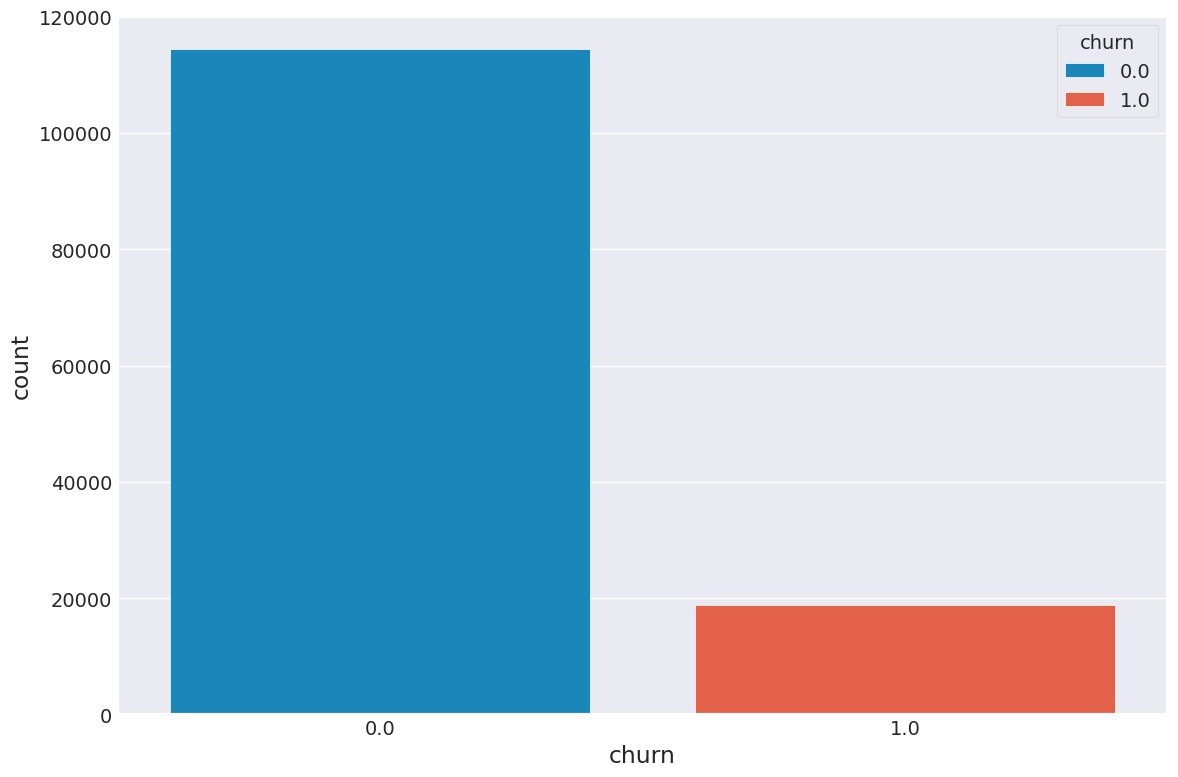

In [18]:
sns.countplot(df, x='churn', hue='churn')
plt.tight_layout()

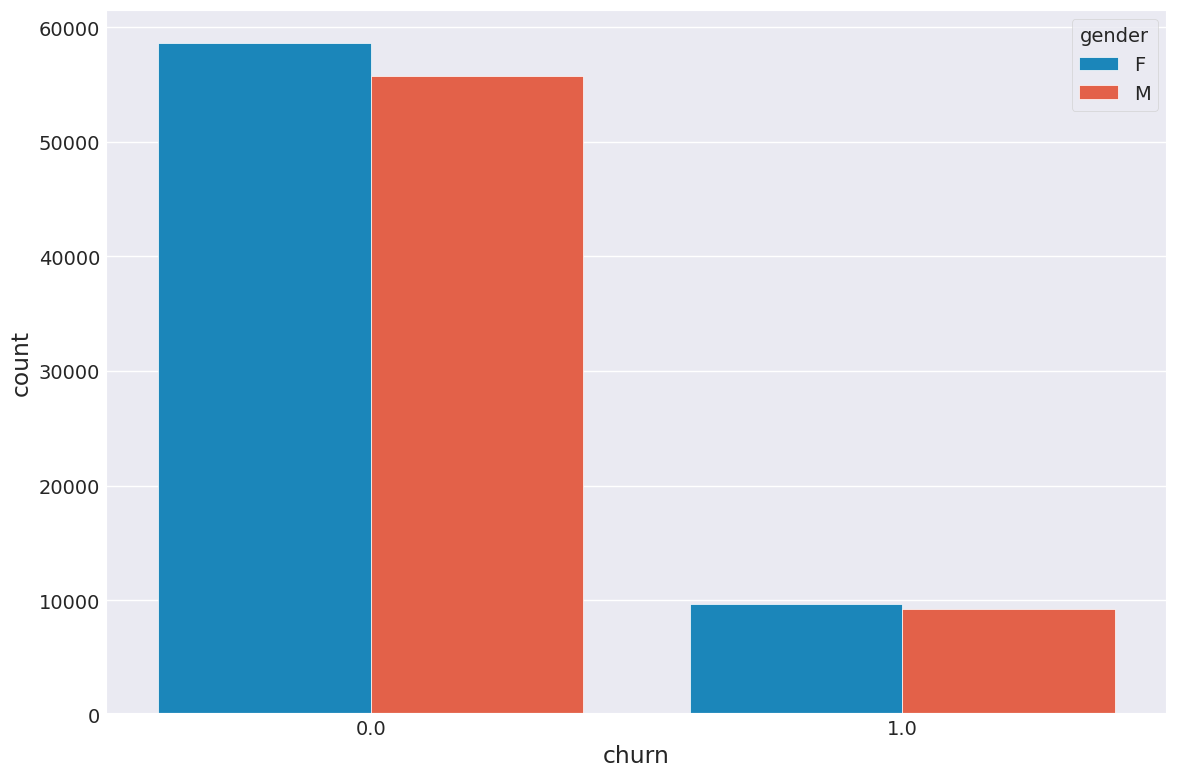

In [19]:
sns.countplot(df, x='churn', hue='gender')
plt.tight_layout()

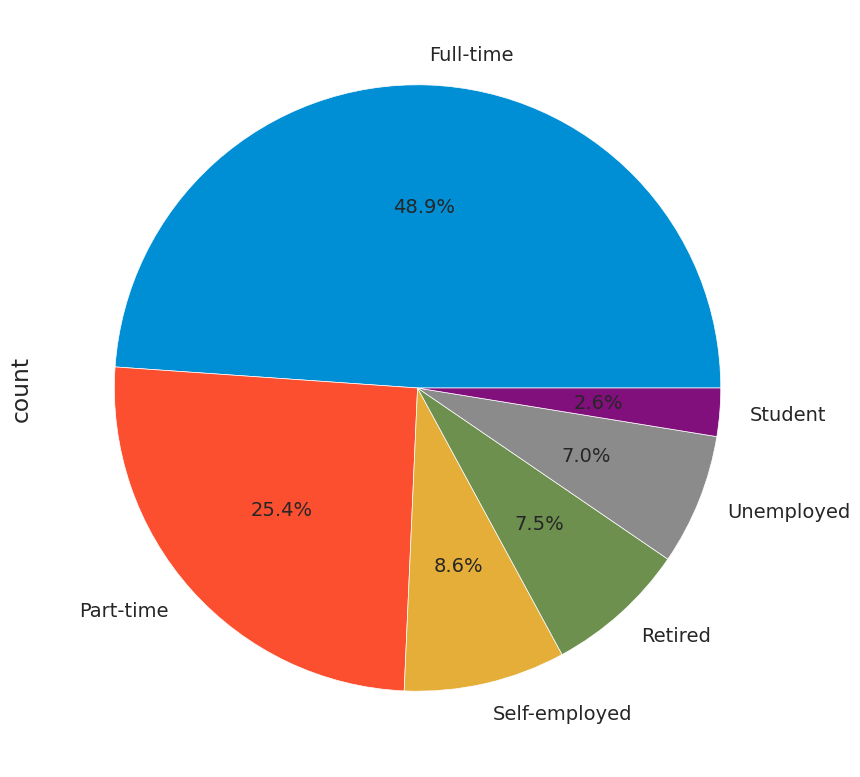

In [20]:
df.work_type.value_counts().plot.pie(autopct='%1.1f%%')
plt.tight_layout()

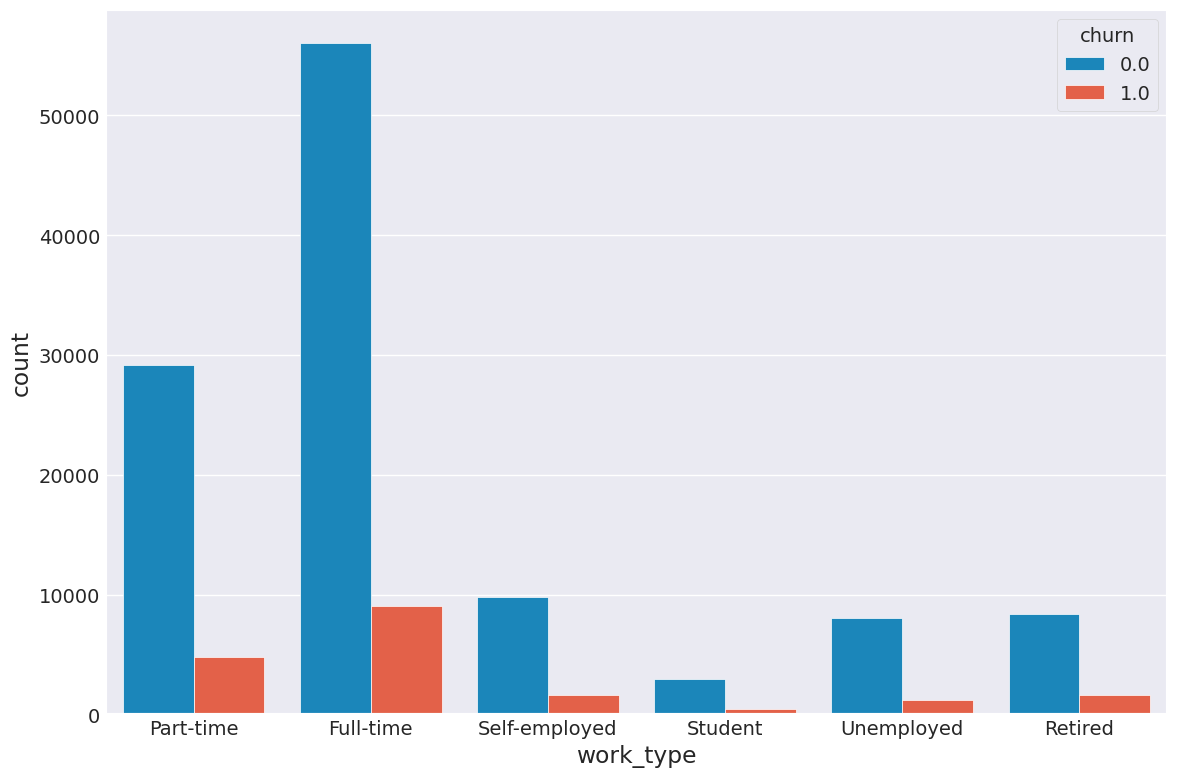

In [21]:
sns.countplot(df, x='work_type', hue='churn')
plt.tight_layout()

In [22]:
df.corr(numeric_only=True)

,cust_id,age,tenure,churn
cust_id,1.000000,0.000433,0.001266,0.000693
age,0.000433,1.000000,0.560941,0.030268
tenure,0.001266,0.560941,1.000000,0.018389
churn,0.000693,0.030268,0.018389,1.000000


In [23]:
customer_history.groupby('cust_id').agg({
    'mobile_eft_all_cnt': ['sum', 'mean', 'max', 'min'],
    'mobile_eft_all_amt': ['sum', 'mean', 'max', 'min'],
    'cc_transaction_all_cnt': ['sum', 'mean', 'max', 'min'],
})

mobile_eft_all_cnt                      mobile_eft_all_amt  \
                       sum      mean   max  min                sum   
cust_id                                                              
0                     47.0  2.238095   5.0  1.0            2578.44   
1                     61.0  1.605263   5.0  0.0             662.14   
2                     87.0  2.351351   5.0  1.0           22569.97   
3                     57.0  1.676471   4.0  1.0            2470.61   
5                     69.0  2.555556   6.0  1.0           10433.95   
...                    ...       ...   ...  ...                ...   
199995                46.0  1.393939   6.0  0.0            3754.57   
199996                60.0  2.000000   5.0  1.0            4778.04   
199997               326.0  9.055556  22.0  1.0          135114.20   
199998                93.0  3.576923   7.0  1.0           16501.11   
199999                 3.0  0.100000   1.0  0.0              10.86   

                                       cc_transaction_all_cnt             \
                mean      max      min                    sum       mean   
cust_id                                                                    
0         122.782857   297.70    31.54                    0.0        NaN   
1          17.424737    83.03     0.00                  543.0  14.289474   
2         609.999189  1436.46    13.41                   73.0   1.972973   
3          72.665000   498.99     1.67                  835.0  24.558824   
5         386.442593  1390.78    64.56                  353.0  13.074074   
...              ...      ...      ...                    ...        ...   
199995    113.774848  1094.64     0.00                 1056.0  32.000000   
199996    159.268000   791.36    24.17                   59.0   1.966667   
199997   3753.172222  7651.39  1386.33                  538.0  14.944444   
199998    634.658077  1612.75    27.36                  518.0  19.923077   
199999      0.362000     4.05     0.00                   62.0   2.066667   

                     
          max   min  
cust_id              
0         NaN   NaN  
1        35.0   3.0  
2         7.0   0.0  
3        49.0  11.0  
5        48.0   1.0  
...       ...   ...  
199995   95.0   1.0  
199996    4.0   0.0  
199997   32.0   3.0  
199998   50.0   1.0  
199999    7.0   0.0  

[176293 rows x 12 columns]

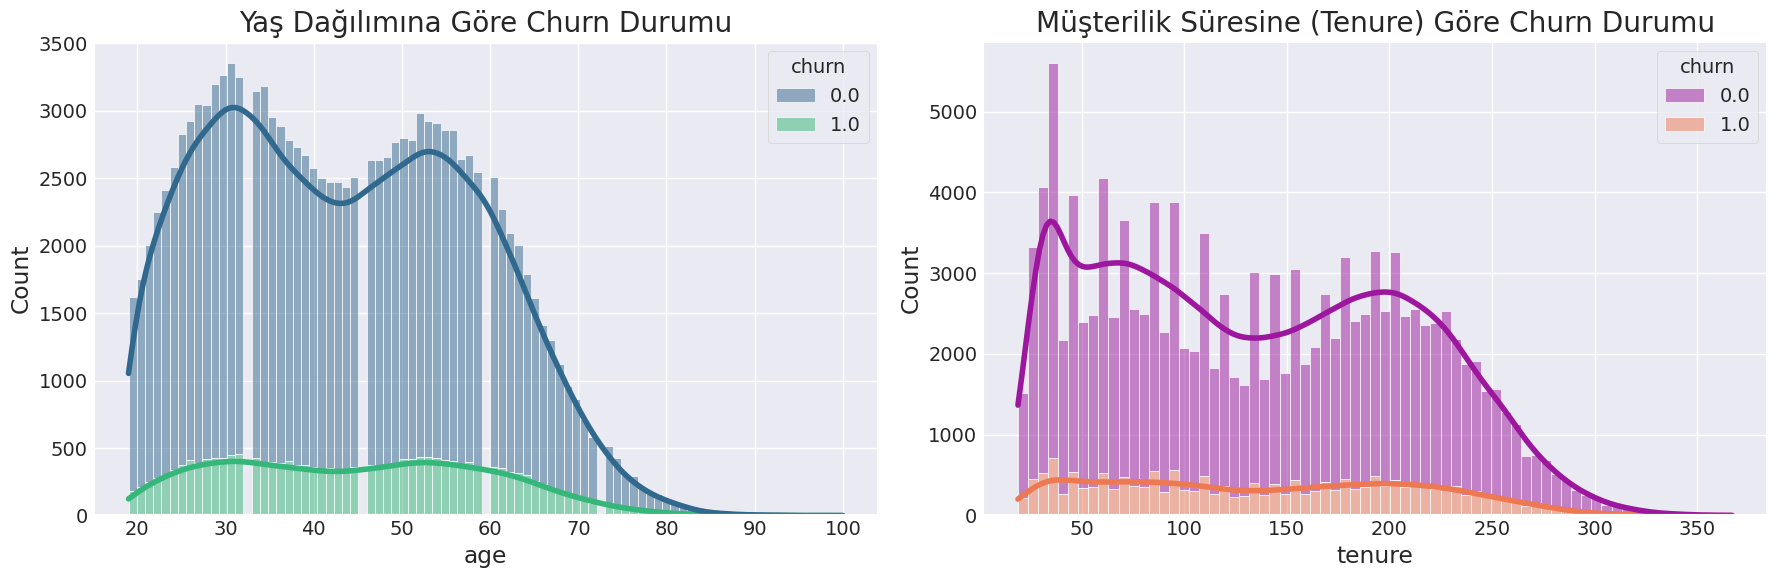

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Yaş dağılımı
sns.histplot(df, x='age', hue='churn', multiple='stack', kde=True, ax=axes[0], palette='viridis')
axes[0].set_title('Yaş Dağılımına Göre Churn Durumu')

# Müşterilik süresi (tenure) dağılımı
sns.histplot(df, x='tenure', hue='churn', multiple='stack', kde=True, ax=axes[1], palette='plasma')
axes[1].set_title('Müşterilik Süresine (Tenure) Göre Churn Durumu')

plt.tight_layout()
plt.show()

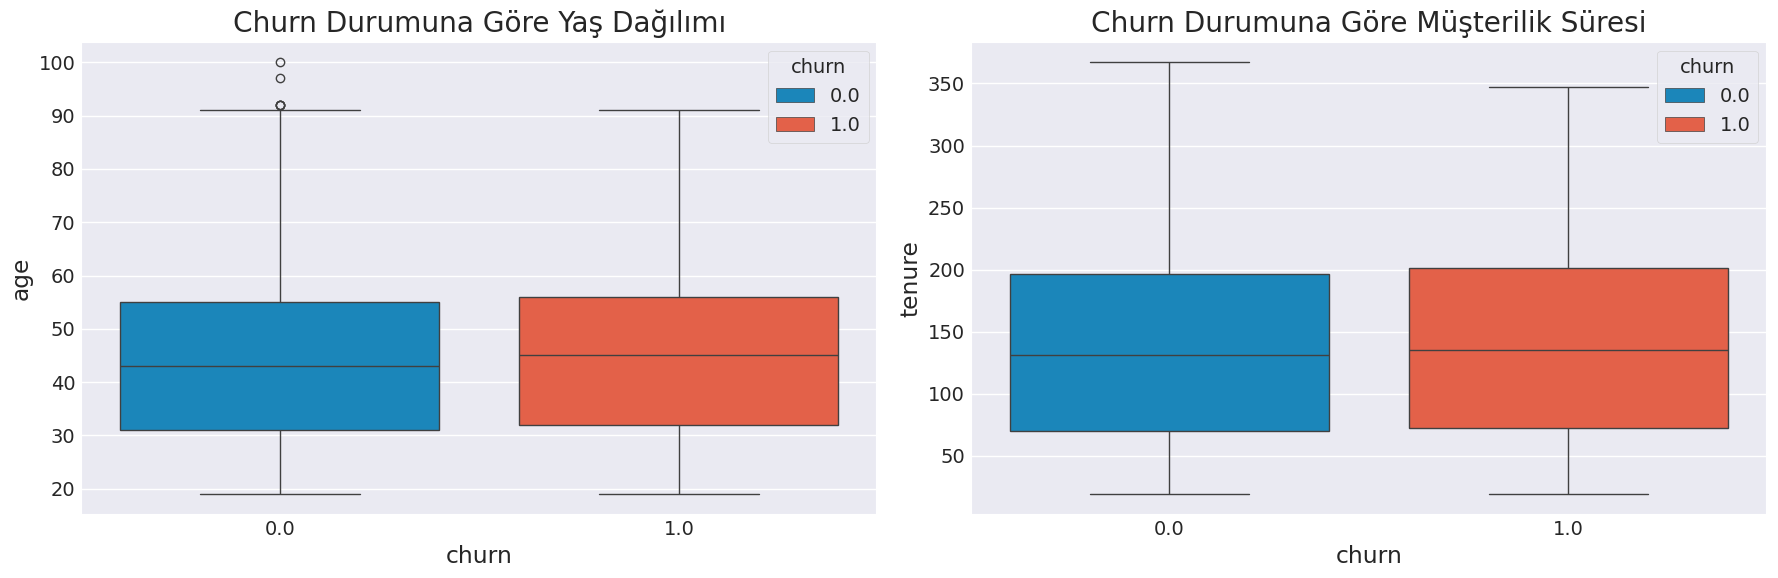

In [25]:
# Kutu grafikleri ile aykırı değerleri ve medyanları karşılaştıralım
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(df, x='churn', y='age', hue='churn', ax=axes[0])
axes[0].set_title('Churn Durumuna Göre Yaş Dağılımı')

sns.boxplot(df, x='churn', y='tenure', hue='churn', ax=axes[1])
axes[1].set_title('Churn Durumuna Göre Müşterilik Süresi')

plt.tight_layout()
plt.show()

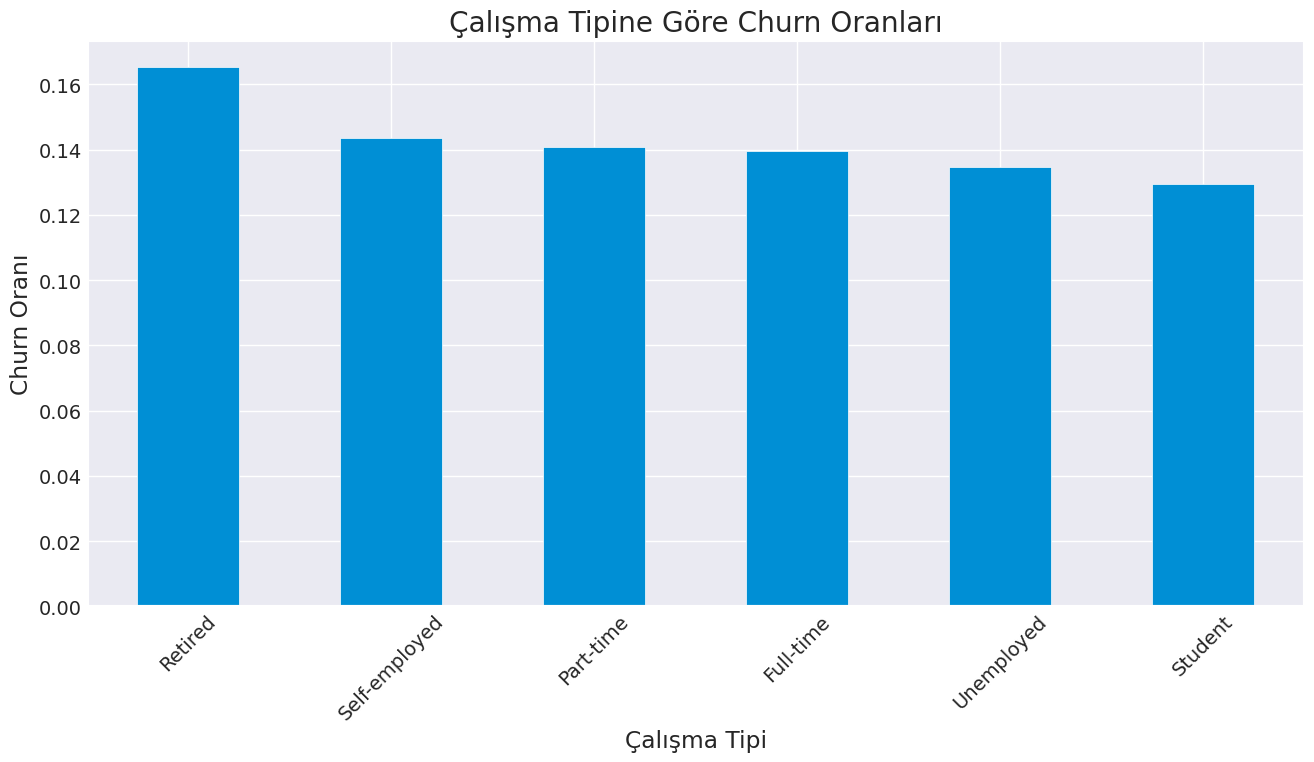

In [26]:
# Çalışma tipine göre churn oranlarını hesaplayıp görselleştirelim
work_type_churn_rate = df.groupby('work_type')['churn'].value_counts(normalize=True).unstack().fillna(0)
work_type_churn_rate[1].sort_values(ascending=False).plot(kind='bar', figsize=(14, 7))

plt.title('Çalışma Tipine Göre Churn Oranları')
plt.ylabel('Churn Oranı')
plt.xlabel('Çalışma Tipi')
plt.xticks(rotation=45)
plt.show()

## 4. Feature Engineering

### 4.1. Veri Hazırlığı: Tarih Formatlarını Dönüştürme

In [27]:
# customer_history ve df'teki tarih sütunlarını datetime formatına çevirelim
customer_history['date'] = pd.to_datetime(customer_history['date'])
df['ref_date'] = pd.to_datetime(df['ref_date'])

### 4.2. Geçmiş Verilerini Referans Tarihine Göre Filtreleme

In [28]:
# Müşteri geçmişini ana dataframe ile birleştir
history_merged = pd.merge(df[['cust_id', 'ref_date']], customer_history, on='cust_id', how='left')

In [29]:
# Sadece referans tarihinden önceki işlem kayıtlarını tut
filtered_history = history_merged[history_merged['date'] < history_merged['ref_date']].copy()

In [30]:
print(f"Orijinal geçmiş kaydı sayısı: {len(history_merged)}")
print(f"Filtrelenmiş geçmiş kaydı sayısı: {len(filtered_history)}")

Orijinal geçmiş kaydı sayısı: 5359609
Filtrelenmiş geçmiş kaydı sayısı: 5183316


### 4.3. Toplulaştırılmış Özellikler Üretme

In [31]:
# Sayısal işlem sütunları için temel istatistikleri (toplam, ortalama, standart sapma, min, max) hesaplayalım.
agg_functions = {
    'mobile_eft_all_cnt': ['sum', 'mean', 'std', 'max'],
    'active_product_category_nbr': ['mean', 'std', 'max'],
    'mobile_eft_all_amt': ['sum', 'mean', 'std', 'max'],
    'cc_transaction_all_amt': ['sum', 'mean', 'std', 'max'],
    'cc_transaction_all_cnt': ['sum', 'mean', 'std', 'max']
}

# Gruplama ve toplulaştırma işlemi
agg_features = filtered_history.groupby('cust_id').agg(agg_functions)

# Sütun isimlerini daha anlaşılır hale getirelim (örneğin: mobile_eft_all_cnt_sum)
agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]

# Eksik değerleri (NaN) 0 ile dolduralım. Örneğin bir müşterinin hiç işlemi yoksa std sapması NaN olacaktır.
agg_features = agg_features.fillna(0)

agg_features.head()

,mobile_eft_all_cnt_sum,mobile_eft_all_cnt_mean,mobile_eft_all_cnt_std,mobile_eft_all_cnt_max,active_product_category_nbr_mean,active_product_category_nbr_std,active_product_category_nbr_max,mobile_eft_all_amt_sum,mobile_eft_all_amt_mean,mobile_eft_all_amt_std,mobile_eft_all_amt_max,cc_transaction_all_amt_sum,cc_transaction_all_amt_mean,cc_transaction_all_amt_std,cc_transaction_all_amt_max,cc_transaction_all_cnt_sum,cc_transaction_all_cnt_mean,cc_transaction_all_cnt_std,cc_transaction_all_cnt_max
cust_id,,,,,,,,,,,,,,,,,,,
0,46.0,2.300000,1.218282,5.0,2.050000,0.223607,3,2365.69,118.284500,58.105908,297.70,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0
1,61.0,1.648649,1.316903,5.0,2.972973,0.164399,3,662.14,17.895676,18.234244,83.03,8722.18,235.734595,208.774759,979.15,535.0,14.459459,8.529669,35.0
2,86.0,2.388889,1.399546,5.0,2.833333,0.377964,3,21759.26,604.423889,468.060451,1436.46,333.63,9.267500,7.810917,19.52,66.0,1.833333,1.828348,7.0
3,55.0,1.666667,1.020621,4.0,3.000000,0.000000,3,1971.62,59.746061,76.944669,333.07,20077.48,608.408485,452.789249,1749.13,814.0,24.666667,10.570202,49.0
5,65.0,2.500000,1.476482,6.0,2.000000,0.000000,2,9710.94,373.497692,354.066609,1390.78,2467.23,94.893462,188.981203,829.67,350.0,13.461538,16.480851,48.0


### 4.4. Zaman Bazlı Özellikler Üretme

In [32]:
# Her müşterinin son işlem tarihini bulalım
last_transaction_dates = filtered_history.groupby('cust_id')['date'].max().reset_index()
last_transaction_dates.columns = ['cust_id', 'last_transaction_date']

# Bu bilgiyi ana df'e ekleyelim
df = pd.merge(df, last_transaction_dates, on='cust_id', how='left')

# "Recency" özelliğini üretelim: Referans tarihi ile son işlem tarihi arasındaki gün farkı
# Eğer hiç işlemi yoksa (NaT), büyük bir değer atayabiliriz (örn. 9999 gün)
df['recency_days'] = (df['ref_date'] - df['last_transaction_date']).dt.days.fillna(9999)

df[['cust_id', 'ref_date', 'last_transaction_date', 'recency_days']].head()

,cust_id,ref_date,last_transaction_date,recency_days
0,0,2017-09-01,2017-08-01,31
1,1,2019-02-01,2019-01-01,31
2,2,2019-01-01,2018-12-01,31
3,3,2018-10-01,2018-09-01,30
4,5,2018-03-01,2018-02-01,28


### 4.5. Tüm Özellikleri Birleştirme

In [33]:
# Ürettiğimiz toplulaştırılmış özellikleri ana df'e ekleyelim
final_df = pd.merge(df, agg_features, on='cust_id', how='left')

# İşlem geçmişi olmayan müşteriler için bu özellikler NaN olacaktır, onları 0 ile dolduralım.
final_df[agg_features.columns] = final_df[agg_features.columns].fillna(0)

# Artık ihtiyaç duymadığımız tarih sütunlarını kaldıralım
final_df = final_df.drop(columns=['ref_date', 'last_transaction_date'])

print("Nihai veri setinin boyutu:", final_df.shape)
final_df.head()

Nihai veri setinin boyutu: (176293, 29)


,cust_id,gender,age,province,religion,work_type,work_sector,tenure,churn,recency_days,mobile_eft_all_cnt_sum,mobile_eft_all_cnt_mean,mobile_eft_all_cnt_std,mobile_eft_all_cnt_max,active_product_category_nbr_mean,active_product_category_nbr_std,active_product_category_nbr_max,mobile_eft_all_amt_sum,mobile_eft_all_amt_mean,mobile_eft_all_amt_std,mobile_eft_all_amt_max,cc_transaction_all_amt_sum,cc_transaction_all_amt_mean,cc_transaction_all_amt_std,cc_transaction_all_amt_max,cc_transaction_all_cnt_sum,cc_transaction_all_cnt_mean,cc_transaction_all_cnt_std,cc_transaction_all_cnt_max
0,0,F,64,NOH,U,Part-time,Technology,135,0.0,31,46.0,2.300000,1.218282,5.0,2.050000,0.223607,3,2365.69,118.284500,58.105908,297.70,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0
1,1,F,57,ZUI,O,Full-time,Finance,65,NaN,31,61.0,1.648649,1.316903,5.0,2.972973,0.164399,3,662.14,17.895676,18.234244,83.03,8722.18,235.734595,208.774759,979.15,535.0,14.459459,8.529669,35.0
2,2,F,62,NOB,M,Self-employed,Healthcare,224,NaN,31,86.0,2.388889,1.399546,5.0,2.833333,0.377964,3,21759.26,604.423889,468.060451,1436.46,333.63,9.267500,7.810917,19.52,66.0,1.833333,1.828348,7.0
3,3,F,22,ZUI,C,Student,NaN,47,0.0,30,55.0,1.666667,1.020621,4.0,3.000000,0.000000,3,1971.62,59.746061,76.944669,333.07,20077.48,608.408485,452.789249,1749.13,814.0,24.666667,10.570202,49.0
4,5,M,27,ZUI,U,Full-time,Finance,108,1.0,28,65.0,2.500000,1.476482,6.0,2.000000,0.000000,2,9710.94,373.497692,354.066609,1390.78,2467.23,94.893462,188.981203,829.67,350.0,13.461538,16.480851,48.0


In [34]:
final_df.isnull().sum()

cust_id                                 0
gender                                  0
age                                     0
province                                0
religion                                0
work_type                               0
work_sector                         30134
tenure                                  0
churn                               43006
recency_days                            0
mobile_eft_all_cnt_sum                  0
mobile_eft_all_cnt_mean                 0
mobile_eft_all_cnt_std                  0
mobile_eft_all_cnt_max                  0
active_product_category_nbr_mean        0
active_product_category_nbr_std         0
active_product_category_nbr_max         0
mobile_eft_all_amt_sum                  0
mobile_eft_all_amt_mean                 0
mobile_eft_all_amt_std                  0
mobile_eft_all_amt_max                  0
cc_transaction_all_amt_sum              0
cc_transaction_all_amt_mean             0
cc_transaction_all_amt_std        

In [35]:
final_df['work_sector'].fillna('Unknown', inplace=True)

In [36]:
final_df.corr(numeric_only=True)['churn'].sort_values(ascending=False)

churn                               1.000000
active_product_category_nbr_std     0.031086
age                                 0.030268
tenure                              0.018389
recency_days                        0.003012
cust_id                             0.000693
cc_transaction_all_amt_std         -0.013725
cc_transaction_all_amt_mean        -0.015149
cc_transaction_all_amt_max         -0.015845
cc_transaction_all_amt_sum         -0.017551
cc_transaction_all_cnt_std         -0.022066
cc_transaction_all_cnt_mean        -0.024667
cc_transaction_all_cnt_max         -0.027354
cc_transaction_all_cnt_sum         -0.028408
mobile_eft_all_amt_std             -0.036835
mobile_eft_all_amt_mean            -0.036895
mobile_eft_all_amt_sum             -0.037333
mobile_eft_all_amt_max             -0.039381
mobile_eft_all_cnt_std             -0.048527
mobile_eft_all_cnt_mean            -0.051706
mobile_eft_all_cnt_sum             -0.052361
mobile_eft_all_cnt_max             -0.053301
active_pro

## 5. Data Preprocessing

In [38]:
final_df.head()

,cust_id,gender,age,province,religion,work_type,work_sector,tenure,churn,recency_days,mobile_eft_all_cnt_sum,mobile_eft_all_cnt_mean,mobile_eft_all_cnt_std,mobile_eft_all_cnt_max,active_product_category_nbr_mean,active_product_category_nbr_std,active_product_category_nbr_max,mobile_eft_all_amt_sum,mobile_eft_all_amt_mean,mobile_eft_all_amt_std,mobile_eft_all_amt_max,cc_transaction_all_amt_sum,cc_transaction_all_amt_mean,cc_transaction_all_amt_std,cc_transaction_all_amt_max,cc_transaction_all_cnt_sum,cc_transaction_all_cnt_mean,cc_transaction_all_cnt_std,cc_transaction_all_cnt_max
0,0,F,64,NOH,U,Part-time,Technology,135,0.0,31,46.0,2.300000,1.218282,5.0,2.050000,0.223607,3,2365.69,118.284500,58.105908,297.70,0.00,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.0
1,1,F,57,ZUI,O,Full-time,Finance,65,NaN,31,61.0,1.648649,1.316903,5.0,2.972973,0.164399,3,662.14,17.895676,18.234244,83.03,8722.18,235.734595,208.774759,979.15,535.0,14.459459,8.529669,35.0
2,2,F,62,NOB,M,Self-employed,Healthcare,224,NaN,31,86.0,2.388889,1.399546,5.0,2.833333,0.377964,3,21759.26,604.423889,468.060451,1436.46,333.63,9.267500,7.810917,19.52,66.0,1.833333,1.828348,7.0
3,3,F,22,ZUI,C,Student,Unknown,47,0.0,30,55.0,1.666667,1.020621,4.0,3.000000,0.000000,3,1971.62,59.746061,76.944669,333.07,20077.48,608.408485,452.789249,1749.13,814.0,24.666667,10.570202,49.0
4,5,M,27,ZUI,U,Full-time,Finance,108,1.0,28,65.0,2.500000,1.476482,6.0,2.000000,0.000000,2,9710.94,373.497692,354.066609,1390.78,2467.23,94.893462,188.981203,829.67,350.0,13.461538,16.480851,48.0


In [39]:
test_df = final_df[final_df['churn'].isnull()]
train_df = final_df[final_df['churn'].notnull()]

In [40]:
# Resampling the dataset
minority = train_df[train_df['churn']==1]
majority = train_df[train_df['churn']==0]
majority_downsampled = resample(majority, replace=False, n_samples=len(minority), random_state=42)
train_df = pd.concat([majority_downsampled, minority])
train_df['churn'].value_counts()

churn
0.0    18870
1.0    18870
Name: count, dtype: int64

In [41]:
x = train_df.drop(columns=['churn', 'cust_id', 'province', 'religion'])
y = train_df['churn']

In [42]:
x_cat = x[['work_type', 'work_sector', 'gender']]
x_num = x.drop(columns=['work_type', 'work_sector', 'gender'])

In [43]:
encoder = OrdinalEncoder()
x_cat = encoder.fit_transform(x_cat)

In [44]:
scaler = MinMaxScaler()
x_num = scaler.fit_transform(x_num)

In [45]:
x_data = np.concatenate([x_cat, x_num], axis=1)

In [46]:
x_data.shape

(37740, 25)

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y, test_size=0.2, random_state=42)

In [48]:
x_train.shape

(30192, 25)

## 6. Model Building

In [49]:
model = xgb.XGBClassifier()
model.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [50]:
y_pred = model.predict(x_test)

In [51]:
accuracy_score(y_test, y_pred)

0.6426868044515104

In [52]:
preprocessor = ColumnTransformer([
    ('encoder', OrdinalEncoder(), ['work_type', 'work_sector', 'gender']),
    ('scaler', MinMaxScaler(), x.select_dtypes(include='number').columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMClassifier(verbose=-1))
])
pipeline.fit(x, y)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('encoder', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
y_pred = pipeline.predict(x)

In [54]:
accuracy_score(y, y_pred)

0.6969263381028087

In [55]:
predictions = pipeline.predict(test_df)
submission = pd.DataFrame({
    'cust_id': test_df['cust_id'],
    'churn': predictions
})
submission.head()

,cust_id,churn
1,1,0.0
2,2,0.0
8,9,0.0
14,15,1.0
18,19,0.0


In [56]:
submission.to_csv('submission.csv', index=False)